In [217]:
import glob
import gzip
import itertools
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
import pandas as pd
import os
from scipy import stats
import sys

from Bio.Seq import Seq
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as offline
from plotly.subplots import make_subplots
import seaborn as sns
from statsmodels.stats import multitest

import matrix_transform
import visualize

%matplotlib inline
sns.set(font="Arial")
sns.set_theme(style="ticks")

In [218]:
fig_folder = 'Figures/'
sample_dir = 'sample_spreadsheet_021521.csv'
samples = pd.read_csv(sample_dir)

amino_acid_list = ['*', 'A', 'C', 'D', 'E', 'F', 'G', 'H',
                   'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R',
                   'S', 'T', 'V', 'W', 'Y']
amino_acid_list.reverse()
grouped_aa = ['H', 'K','R','D','E','C','M','N','Q','S','T','A',\
             'I','L','V','F','W','Y','G','P','*']
grouped_aa_r = ['*', 'P', 'G', 'Y', 'W', 'F', 'V', 'L', 'I',\
               'A', 'T', 'S', 'Q', 'N', 'M', 'C', 'E', 'D', 'R',\
               'K', 'H']

wt_ = ('SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDM'
       'LNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTP'
       'KYKFVRIQPGQTFSVLFLNGSCGSVG'
       'FNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTT'
       'ITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDI'
       'LGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ*')
wt_full = ('MSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICT'
           'SEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKV'
           'DTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIK'
           'GSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYG'
           'PFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLND'
           'FNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNG'
           'MNGRTILGSALLEDEFTPFDVVRQCSGVTFQ')
wt_ = [x for x in wt_]
wt_full = [x for x in wt_full]

sets = [1, 2, 3, 4, 5, 6, 7,8, 9, 10, 11, 12, 13,\
        14, 15, 16, 17, 18, 19, 20, 21, 'R1']
res_redo = ['8R', '9R1', '9R2', '10R1', '10R2',\
            '13R1', '13R2', '14R', '16R']

all_sets = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 
        17, 18, 19, 20, 21, 8, 9, 10, 'R1', '8R', '9R1', '9R2',
        '10R1', '10R2', '13R1', '13R2', '14R', '16R']

In [219]:
def set_res(x):
    
    '''Look up value at residue and return the set that the residue
    belongs to.'''
    
    return set_res_dict[x]

def activity_gal(x):
    '''
    Look up value at residue and amino acid in the glu_gal data
    as referenced by output of raw_dist.
    '''
    return(all_residues['Res '+str(x['residue'])].loc[x['middle']])

def activity_gc(x):
    '''
    Look up value at residue and amino acid in the gc_gal data
    as referenced by output of raw_dist.
    '''
    return(all_residues_gc['Res '+str(x['residue'])].loc[x['middle']])

def activity_grl(x):
    '''Look up value at residue and amino acid in the grl_gal data
    as referenced by output of raw_dist.'''
    return(all_residues_grl['Res '+str(x['residue'])].loc[x['middle']])

### Main heatmap figure

In [220]:
# Construct dictionary for residue to set correspondence
set_res_correspond = samples[['Set', 'Start range', 'End range']].drop_duplicates()
set_res_dict = {}
for ind, row in set_res_correspond.iterrows():
    for residue in range(row['Start range'], row['End range']):
        set_res_dict[residue] = row['Set']

# Construct dictionary linking residue of interest and standard deviation
# of values for the set. 

glu_gal_sigmas = matrix_transform.transform_sigma('new_glu_gal', 'gal_glu.csv',\
                                    samples, sets, res_redo, all_sets)
glu_gal_dict = dict(glu_gal_sigmas)
glu_gc_sigmas = matrix_transform.transform_sigma('new_glu_gc', 'glu_gc.csv',\
                                    samples, sets, res_redo, all_sets)
glu_gc_dict = dict(glu_gc_sigmas)
glu_grl_sigmas = matrix_transform.transform_sigma('new_glu_grl', 'glu_grl.csv',\
                                    samples, sets, res_redo, all_sets)
glu_grl_dict = dict(glu_grl_sigmas)

glu_gal_dict = {str(k):v for k,v in glu_gal_dict.items()}
glu_gc_dict = {str(k):v for k,v in glu_gc_dict.items()}  
glu_grl_dict = {str(k):v for k,v in glu_grl_dict.items()}  

def gal_sigma(x):
    '''Return the scaling factor of the raw data in the gal condition.'''
    return glu_gal_dict[x]

def gc_sigma(x):
    '''Return the scaling factor of the raw data in the gal condition.'''
    return glu_gc_dict[x]

def grl_sigma(x):
    '''Return the scaling factor of the raw data in the gal condition.'''
    return glu_grl_dict[x]

### Glucose/Galactose figures

#### Regularized variance to 1 and wt set to 0 for each set

In [221]:
subplot_titles = ["Set 1", "Set 2", "Set 3", "Set 4",\
                   "Set 5", "Set 6", "Set 7", "Set 11", "Set 12", "Set 13",\
                   "Set 14", "Set 15", "Set 16", "Set 17",\
                   "Set 18", "Set 19", "Set 20", "Set 21",
                   "Set 8", "Set 9", "Set 10", 'R1', '8R', '9R1', '9R2',
                   '10R1', '10R2', '13R1', '13R2', '14R', '16R'
                  ]
matrix_transform.transform_dist_sigma(
        'new_glu_gal', 'gal_glu.csv', subplot_titles, samples,\
        sets, res_redo, all_sets, \
        title = 'Raw distributions of foldchange over wildtype in gal/glu')

### Make heatmap of transformed data by set

In [222]:
all_residues, mean_stop_dict = matrix_transform.transform_matrix_sigma(
            'new_glu_gal', 'gal_glu.csv', samples, sets, res_redo, all_sets)
visualize.make_heatmap(all_residues, [int(x[4:]) for x in list(all_residues.columns)], \
            grouped_aa, wt_full[1:], show = True, 
            save = False, name = fig_folder+'glu_gal_standardize')

In [223]:
all_residues.to_csv('CSVs/glu_gal_standardize.csv')

### Activity of all variants with standardized normalization

In [224]:
flat = [item for sublist in all_residues.values for item in sublist]
flat = [x for x in flat if str(x) != 'nan']

# Import clinical variant details
single_muts = 'CSVs/single_mutations_broad_GISAID.csv'
single_muts = pd.read_csv(single_muts)
single_muts['residue'] = single_muts['residue']
single_muts = single_muts.melt(id_vars = 'residue').dropna()

# Find values in heatmap of all detected clinical variants
pat_vars = []
for ind, row in single_muts.iterrows():
    pat_vars.append(all_residues['Res '+str(row['residue'])].loc[row['value']])
    

In [225]:
# Visualize the distribution of the relative fitnesses
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Histogram(x=flat, 
                           opacity=0.75, marker_color = '#D81B60', name='All residues',
                           xbins=dict( # bins used for histogram
                            size=0.125
                        )),
             secondary_y=False)

fig.add_trace(go.Histogram(x=pat_vars,opacity=0.75, marker_color = '#1E88E5',
                           name='Clinical isolates',
                          xbins=dict( # bins used for histogram
                            size=0.125
                        )),
              secondary_y=True)

fig.update_yaxes(title_text="Number (all residues)", secondary_y=False)
fig.update_yaxes(title_text="Number (clinical isolates)", secondary_y=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,
                showgrid=False)
fig.update_layout(
    title="Protease activity",
    xaxis_title="Activity score",
    paper_bgcolor='rgba(255,255,255,100)',
    plot_bgcolor='rgba(255,255,255,100)',
    font=dict(family="Arial",
                    size=16)
    
    )
fig.show()
fig.write_image(fig_folder+"Fig2_standardized_activity_all_and_clinical.pdf")

Allows us to set a cutoff for activity at -1.2.

### Glucose/GC376

#### Raw data distribution from glu/gc

In [226]:
subplot_titles = ["Set 1", "Set 2", "Set 3", "Set 4",\
                   "Set 5", "Set 6", "Set 7", "Set 11", "Set 12", "Set 13",\
                   "Set 14", "Set 15", "Set 16", "Set 17",\
                   "Set 18", "Set 19", "Set 20", "Set 21",
                   "Set 8", "Set 9", "Set 10", 'R1', '8R', '9R1', '9R2',
                    '10R1', '10R2', '13R1', '13R2', '14R', '16R']
matrix_transform.original_dist(
            'new_glu_gc', 'glu_gc.csv', subplot_titles, samples,\
            sets, res_redo, all_sets,
            title = 'Raw distributions of foldchange over wildtype in gc/glu')

#### Regularized variance to 1 and wt set to 0 for each set

In [227]:
subplot_titles = ["Set 1", "Set 2", "Set 3", "Set 4",\
                   "Set 5", "Set 6", "Set 7", "Set 11", "Set 12", "Set 13",\
                   "Set 14", "Set 15", "Set 16", "Set 17",\
                   "Set 18", "Set 19", "Set 20", "Set 21",
                   "Set 8", "Set 9", "Set 10", 'R1', '8R', '9R1', '9R2',
                    '10R1', '10R2', '13R1', '13R2', '14R', '16R']
matrix_transform.transform_dist_sigma(
            'new_glu_gc', 'glu_gc.csv', subplot_titles, samples,\
            sets, res_redo, all_sets,
            title = 'Raw distributions of foldchange over wildtype in gc/glu')

In [228]:
all_residues, mean_stop_dict= matrix_transform.transform_matrix_sigma(
        'new_glu_gc', 'glu_gc.csv', samples, sets, res_redo, all_sets)
all_residues.to_csv('CSVs/glu_gc_standardize.csv')

### Compare glu/gal to glu/gc data

In [229]:
all_residues, mean_stop_dict = matrix_transform.transform_matrix_sigma(
        'new_glu_gal', 'gal_glu.csv',samples, sets, res_redo, all_sets)
all_residues_gc, mean_stop_dict= matrix_transform.transform_matrix_sigma(
        'new_glu_gc', 'glu_gc.csv', samples, sets, res_redo, all_sets)

# plot glu/gc against glu/gal
all_residues_melt = all_residues.reset_index().melt(id_vars = 'index')
all_residues_gc_melt = all_residues_gc.reset_index().melt(id_vars = 'index')
gal_gc_melt = all_residues_melt.merge(all_residues_gc_melt, on = ['index', 'variable'])

In [230]:
fig = px.scatter(gal_gc_melt, x = 'value_x', y = 'value_y', 
                 hover_data=["index",
                             "variable"])
# add a line denoting x=y as visual aid
fig.add_trace(go.Scatter(x=[-5, 2], y =[-5,2]))
fig.show()

#### Incorporate error bars

In [231]:
gal_error = matrix_transform.raw_dist('amino_acid_glu_gal', samples,
                                     sets, res_redo, all_sets)
gal_error['standardize_gal'] = gal_error.apply(activity_gal, axis = 1)
gc_error = matrix_transform.raw_dist('amino_acid_glu_gc', samples,
                                     sets, res_redo, all_sets)
gc_error['standardize_gc'] = gc_error.apply(activity_gc, axis = 1)
gal_gc_df = gal_error.merge(gc_error, left_on = ['Translation', 'residue', 'middle'], \
          right_on = ['Translation', 'residue',  'middle'], \
          suffixes = ('_gal', '_gc'))

The regression will be performed on the standardized values. However the standard errors have to be normalized by the standard deviations of the raw means of the set. Because the normalization was performed by set, we need to add a column indicating the experimental set that the residue belongs to. This is stored in the dictionary set_res_dict.

In [232]:
#add column corresponding to set
gal_gc_df.residue = gal_gc_df.residue.astype(int)
gal_gc_df['set'] = gal_gc_df.residue.apply(set_res)

Now we want to transform the std error for each residue by dividing by the standard deviation of the raw data of that set. These are stored in dictionaries glu_gal_dict, gal_gc_dict, gal_grl_dict. 

In [233]:
gal_gc_df.set = gal_gc_df.set.astype(str)
gal_gc_df['raw_gal_error'] = gal_gc_df.set.apply(gal_sigma)
gal_gc_df['raw_gc_error'] = gal_gc_df.set.apply(gc_sigma)

gc_stats = gal_gc_df[['set', 'residue', 'middle', 
                      'standardize_gal', 'std_gal',
                      'standardize_gc', 'std_gc',
                       'raw_gal_error', 'raw_gc_error', 'len_gc', 'len_gal']].copy()
gc_stats['transform_error_gal'] = gc_stats['std_gal']/(gc_stats['raw_gal_error']*\
                                                                   np.sqrt(gc_stats['len_gal']))
gc_stats['transform_error_gc'] = gc_stats['std_gc']/(gc_stats['raw_gc_error']*\
                                                                   np.sqrt(gc_stats['len_gc']))
# consider only variants with replicates
gc_stats = gc_stats[(gc_stats['len_gc']>1) & (gc_stats['len_gal']>1)]
# consider only active variants
gc_stats = gc_stats[gc_stats['standardize_gal']>-1.2]

Calculate the p-values given the means and standard deviations and well as number of observations for each condition and perform multiple testing correction. 

In [234]:
test_stat_list = []
for ind, row in gc_stats.iterrows():
    test_stat = stats.ttest_ind_from_stats(mean1 = row['standardize_gal'], 
                                           std1 = row['transform_error_gal'],
                                           nobs1 = row['len_gal'],
                                           mean2 = row['standardize_gc'], 
                                           std2 = row['transform_error_gc'],
                                           nobs2 = row['len_gc'])
    test_stat_list.append([row['residue'], row['middle'], test_stat])
    
tstats_gc = pd.DataFrame(test_stat_list, columns = ['residue', 'amino_acid', 'stats'])
tstats_gc['pval'] = [x[1] for x in tstats_gc['stats']]
tstats_gc['tstat'] = [x[0] for x in tstats_gc['stats']]
truth_p, corrected_p, sidak_a, bonf_a = multitest.multipletests(tstats_gc['pval'], alpha = 0.05)
tstats_gc['corrected_p'] = corrected_p
tstats_gc['hit'] = truth_p
gc_stats = gc_stats.merge(tstats_gc, left_on = ['residue', 'middle'], 
              right_on = ['residue', 'amino_acid'])

In [235]:
fig = px.scatter(gc_stats, x = 'standardize_gal', y = 'standardize_gc', 
                 hover_data=["residue",
                             "middle"], color = 'hit')
fig.add_trace(go.Scatter(x=[-5, 2], y =[-5,2]))
fig.show()
# plotly.offline.plot(fig, filename = fig_folder+'gc_gal_scatter_active.html')

In [236]:
gc_stats.to_csv('CSVs/gc_resistance_stats.csv')

### Compare glu/gal to glu/grl data

In [237]:
all_residues, mean_stop_dict = matrix_transform.transform_matrix_sigma(
        'new_glu_gal', 'gal_glu.csv',samples, sets, res_redo, all_sets)
all_residues_grl, mean_stop_dict= matrix_transform.transform_matrix_sigma(
        'new_glu_grl', 'glu_grl.csv', samples, sets, res_redo, all_sets)

# plot glu/gc against glu/gal
all_residues_melt = all_residues.reset_index().melt(id_vars = 'index')
all_residues_grl_melt = all_residues_grl.reset_index().melt(id_vars = 'index')
gal_grl_melt = all_residues_melt.merge(all_residues_grl_melt, on = ['index', 'variable'])

In [238]:
fig = px.scatter(gal_grl_melt, x = 'value_x', y = 'value_y', 
                 hover_data=["index",
                             "variable"])
fig.add_trace(go.Scatter(x=[-5, 2], y =[-5,2]))
fig.show()

 #### Incorporate error bars

In [239]:
gal_error = matrix_transform.raw_dist('amino_acid_glu_gal', samples,
                                     sets, res_redo, all_sets)
gal_error['standardize_gal'] = gal_error.apply(activity_gal, axis = 1)
grl_error = matrix_transform.raw_dist('amino_acid_glu_grl', samples,
                                     sets, res_redo, all_sets)
grl_error['standardize_grl'] = grl_error.apply(activity_grl, axis = 1)
gal_grl_df = gal_error.merge(grl_error, left_on = ['Translation', 'residue', 'middle'], \
          right_on = ['Translation', 'residue',  'middle'], \
          suffixes = ('_gal', '_grl'))

In [240]:
#add column corresponding to set
gal_grl_df.residue = gal_grl_df.residue.astype(int)
gal_grl_df['set'] = gal_grl_df.residue.apply(set_res)

In [241]:
gal_grl_df.set = gal_grl_df.set.astype(str)
gal_grl_df['raw_gal_error'] = gal_grl_df.set.apply(gal_sigma)
gal_grl_df['raw_grl_error'] = gal_grl_df.set.apply(grl_sigma)

grl_stats = gal_grl_df[['set', 'residue', 'middle', 
                      'standardize_gal', 'std_gal',
                      'standardize_grl', 'std_grl',
                       'raw_gal_error', 'raw_grl_error', 'len_grl', 'len_gal']].copy()
grl_stats['transform_error_gal'] = grl_stats['std_gal']/(grl_stats['raw_gal_error']*\
                                                                   np.sqrt(grl_stats['len_gal']))
grl_stats['transform_error_grl'] = grl_stats['std_grl']/(grl_stats['raw_grl_error']*\
                                                                   np.sqrt(grl_stats['len_grl']))
# consider only variants with replicates
grl_stats = grl_stats[(grl_stats['len_grl']>1) & (grl_stats['len_gal']>1)]
# consider only active variants
grl_stats = grl_stats[grl_stats['standardize_gal']>-1.2]

Calculate adjusted p-values

In [242]:
test_stat_list = []
for ind, row in grl_stats.iterrows():
    test_stat = stats.ttest_ind_from_stats(mean1 = row['standardize_gal'], 
                                           std1 = row['transform_error_gal'],
                                           nobs1 = row['len_gal'],
                                           mean2 = row['standardize_grl'], 
                                           std2 = row['transform_error_grl'],
                                           nobs2 = row['len_grl'])
    test_stat_list.append([row['residue'], row['middle'], test_stat])
    
tstats_grl = pd.DataFrame(test_stat_list, columns = ['residue', 'amino_acid', 'stats'])
tstats_grl['pval'] = [x[1] for x in tstats_grl['stats']]
tstats_grl['tstat'] = [x[0] for x in tstats_grl['stats']]
truth_p, corrected_p, sidak_a, bonf_a = multitest.multipletests(tstats_grl['pval'], alpha = 0.05)
tstats_grl['corrected_p'] = corrected_p
tstats_grl['hit'] = truth_p
grl_stats = grl_stats.merge(tstats_grl, left_on = ['residue', 'middle'], 
              right_on = ['residue', 'amino_acid'])

/Users/jennysheng/anaconda3/envs/tools/lib/python3.6/site-packages/statsmodels/stats/multitest.py:160: RuntimeWarning:

invalid value encountered in greater

/Users/jennysheng/anaconda3/envs/tools/lib/python3.6/site-packages/statsmodels/stats/multitest.py:254: RuntimeWarning:

invalid value encountered in greater



In [243]:
fig = px.scatter(grl_stats, x = 'standardize_gal', y = 'standardize_grl', 
                 hover_data=["residue",
                             "middle"], color = 'hit')
fig.add_trace(go.Scatter(x=[-5, 2], y =[-5,2]))
fig.show()
# plotly.offline.plot(fig, filename = fig_folder+'gc_gal_scatter_active.html')

In [244]:
grl_stats.to_csv('CSVs/grl_resistance_stats.csv')

### Make resistance map

In [245]:
gc_stats = gc_stats.drop_duplicates(subset = ['residue', 'middle'], keep = 'last').copy()
gc_color = []
for ind, row in gc_stats.iterrows():
    if row['hit'] == False:
        gc_color.append(0)
    elif row['standardize_gc'] > row['standardize_gal']:
        gc_color.append(1)
    else:
        gc_color.append(2)
gc_stats['color'] = gc_color

grl_stats = grl_stats.drop_duplicates(subset = ['residue', 'middle'], keep = 'last').copy()
grl_color = []
for ind, row in grl_stats.iterrows():
    if row['hit'] == False:
        grl_color.append(0)
    elif row['standardize_grl'] > row['standardize_gal']:
        grl_color.append(1)
    else:
        grl_color.append(2)
grl_stats['color'] = grl_color

In [246]:
gc_matrix = gc_stats.pivot(index = 'middle', columns = 'residue', values = 'color').fillna(0)
gc_matrix = gc_matrix.reindex(grouped_aa)
gc_array = gc_matrix.to_numpy()

grl_matrix = grl_stats.pivot(index = 'middle', columns = 'residue', values = 'color').fillna(0)
grl_matrix = grl_matrix.reindex(grouped_aa)
grl_array = grl_matrix.to_numpy()

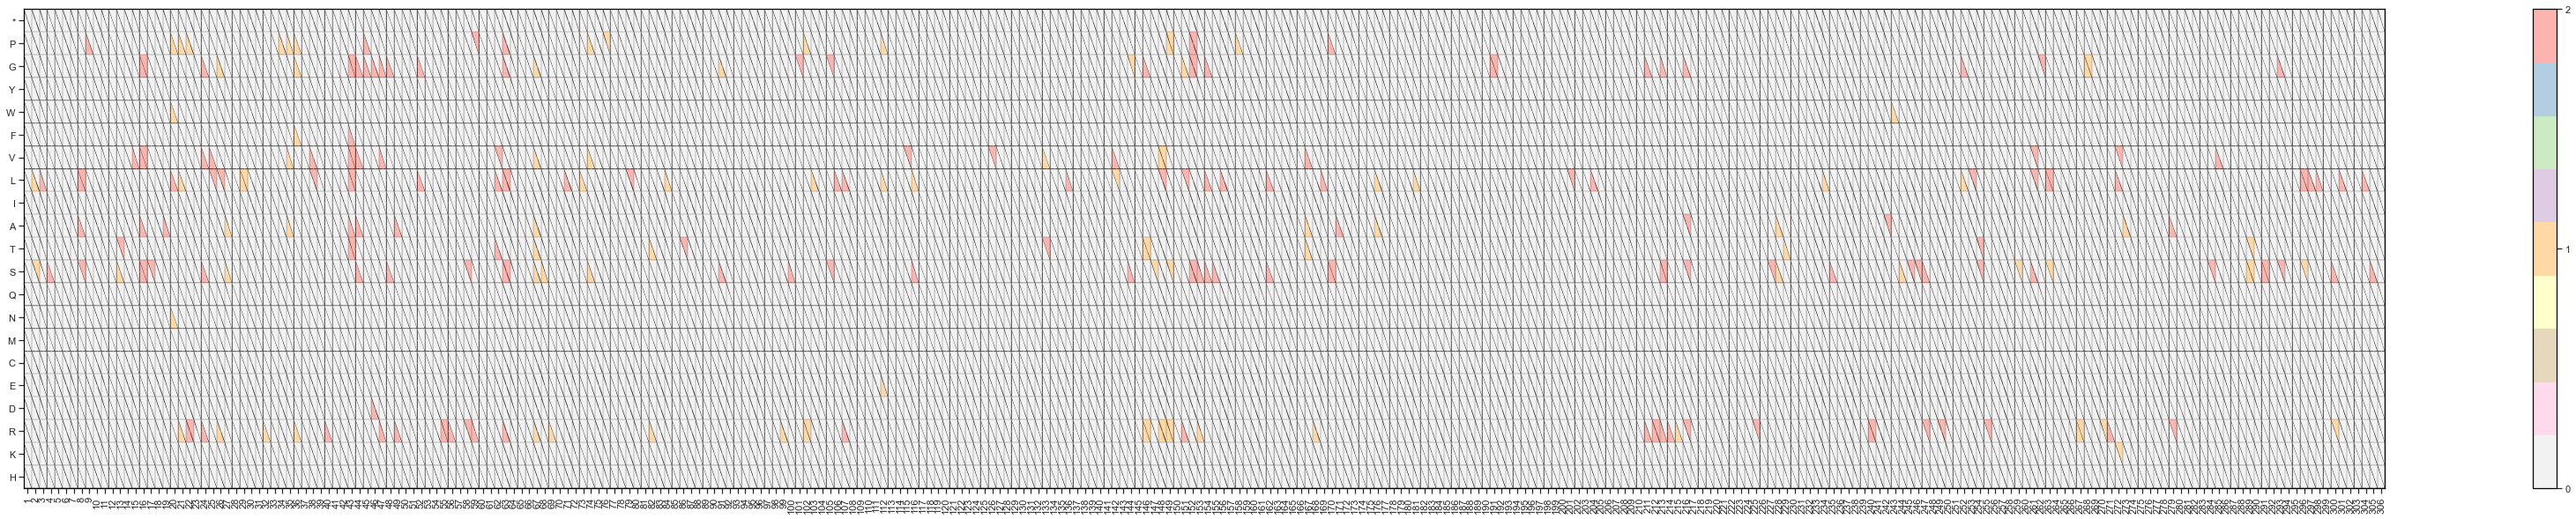

In [247]:
plt.rcParams["figure.figsize"] = (60,10)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"

M = 306
N = 21
x = np.arange(M + 1)
y = np.arange(N + 1)
xs, ys = np.meshgrid(x, y)

z_grl = grl_array.ravel()
z_gc = gc_array.ravel()

triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
triang1 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles1)
triang2 = Triangulation(xs.ravel()-0.5, ys.ravel()-0.5, triangles2)
img1 = plt.tripcolor(triang1, z_grl, cmap=plt.get_cmap('Pastel1_r'), 
                    edgecolor='k')
img2 = plt.tripcolor(triang2, z_gc, cmap=plt.get_cmap('Pastel1_r'),
                    edgecolor='k')

plt.xlim(x[0]-0.5, x[-1]-0.5)
plt.ylim(y[0]-0.5, y[-1]-0.5)
plt.colorbar(img1, ticks=range(3))
plt.grid(True)
plt.xticks(x[:-1], x[1:], rotation = 90)
plt.yticks(y[:-1], grouped_aa)
plt.axis('on')
plt.savefig('Figures/drug_resistance_hits.png', dpi=250, bbox_inches='tight')
plt.show()